In [81]:
import spacy
from spacy.training import Example

import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [83]:
# Loading the dataset
SA_dataset = pd.read_csv('SA_dataset.csv')

## Data analysis

In [84]:
# Showing the first 5 rows of the dataset
SA_dataset.head()

,Review,Rating,Sentiment
0,**Possible Spoilers**,1,0
1,"Read the book, forget the movie!",2,0
2,**Possible Spoilers Ahead**,2,0
3,"What a script, what a story, what a mess!",2,0
4,I hope this group of film-makers never re-unites.,1,0


In [85]:
# Computing some statistics for the numerical columns
SA_dataset.describe()

,Rating,Sentiment
count,5000.000000,5000.000000
mean,5.902200,0.550000
std,3.653944,0.497543
min,1.000000,0.000000
25%,2.000000,0.000000
50%,7.000000,1.000000
75%,10.000000,1.000000
max,10.000000,1.000000


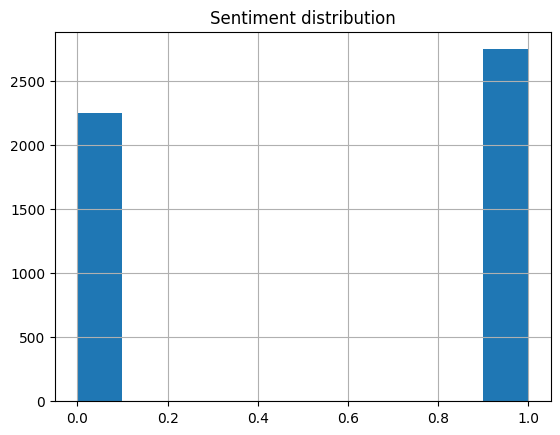

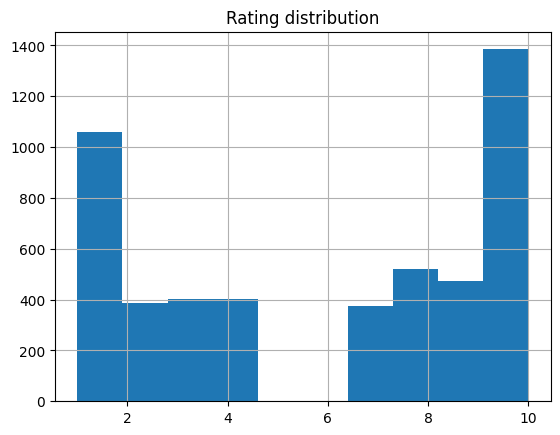

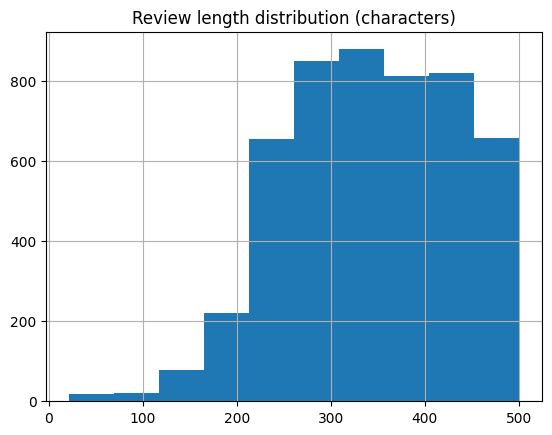

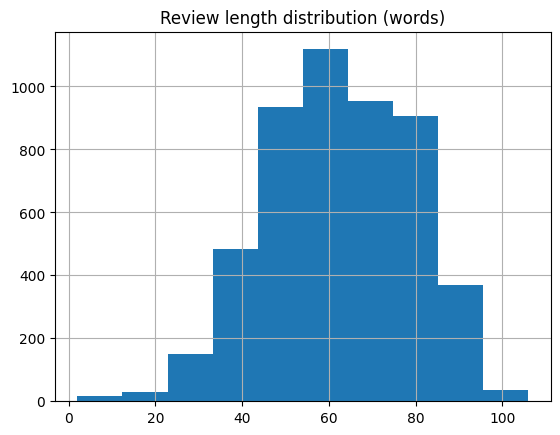

In [86]:
SA_dataset["Sentiment"].hist()
plt.title('Sentiment distribution')
plt.show()

SA_dataset["Rating"].hist()
plt.title('Rating distribution')
plt.show()

SA_dataset["Review"].str.len().hist()
plt.title('Review length distribution (characters)')
plt.show()

SA_dataset["Review"].str.split().apply(len).hist()
plt.title('Review length distribution (words)')
plt.show()

In [87]:
# Obtaining the frequency distribution of the words
freq_dist = SA_dataset['Review'].str.split(expand=True).unstack().dropna() # Splitting the reviews into words by spaces

# Loading the english stop words
StopWords = stopwords.words('english')

# Filtering the frequency distribution to remove the stop words and obtaining the 10 most common words
freq_dist = Counter({word:count for word, count in freq_dist.value_counts().items()
                     if word.lower() not in StopWords})
freq_dist.most_common(10)

[('movie', 3349),
 ('film', 1862),
 ('one', 1516),
 ('like', 1070),
 ('good', 1056),
 ('see', 849),
 ('great', 832),
 ('really', 774),
 ('movie.', 702),
 ('story', 688)]

In [90]:
# Showing the frequency distribution of the words
print(freq_dist)

Counter({'movie': 3349, 'film': 1862, 'one': 1516, 'like': 1070, 'good': 1056, 'see': 849, 'great': 832, 'really': 774, 'movie.': 702, 'story': 688, 'bad': 643, 'it.': 618, 'even': 611, 'ever': 610, 'would': 597, 'best': 528, 'movies': 510, 'time': 498, 'watch': 497, 'seen': 495, 'acting': 491, 'film.': 468, 'much': 466, 'think': 451, 'make': 450, 'made': 448, 'get': 445, 'could': 442, 'plot': 434, 'love': 420, '-': 419, 'first': 415, 'well': 383, 'never': 365, 'people': 360, 'movie,': 353, 'worst': 345, 'better': 343, 'little': 337, 'saw': 311, 'characters': 309, 'still': 297, "I've": 296, 'worth': 296, 'also': 291, 'know': 288, 'many': 288, 'funny': 285, 'watching': 281, 'way': 278, 'say': 278, 'films': 272, 'want': 267, 'thought': 265, 'makes': 253, 'must': 248, 'cast': 244, 'give': 244, 'two': 243, 'go': 240, 'actors': 238, 'got': 231, 'lot': 229, "I'm": 223, 'real': 223, 'every': 222, 'action': 216, 'character': 214, 'it,': 212, "can't": 210, 'find': 208, 'time.': 207, 'look': 206

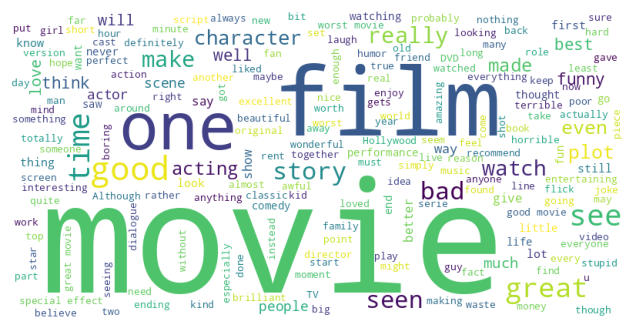

In [ ]:
# Generating a word cloud for the reviews
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          background_color='white'
                          ).generate(text)

    fig = plt.figure(1, figsize=(8, 4))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.savefig("WordCloud.png")

text = " ".join(SA_dataset['Review'].values)
generate_wordcloud(text)

In [5]:
# Train-test split

X = SA_dataset['Review'].values
y = SA_dataset['Sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Classifier ussing spacy pipeline

In [ ]:
# Loading the model
model = spacy.load('en_core_web_md')
model.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [ ]:
# Adding the text categorization component to the model pipeline
textcat = model.add_pipe('textcat', last=True)

In [ ]:
# Generating an input example for the model, in order to initialize the text categorization component
input = Example.from_dict(model.make_doc('It was great'), {'cats': {'POSITIVE': 1.0, 'NEGATIVE': 0.0}})

# Initializing the text categorization component
textcat.initialize(lambda: [input], nlp=model)

In [ ]:
# Create the optimizer
optimizer = model.resume_training()

In [ ]:
# A function to transform the reviews into the neded format for the model
def create_examples(X, y):
    examples = []
    for text, label in zip(X, y):
        doc = model.make_doc(text)
        examples.append(Example.from_dict(doc, {'cats': {'POSITIVE': int(label), 'NEGATIVE': int(not label)}}))
    return examples

train_examples = create_examples(X_train, y_train)
test_examples = create_examples(X_test, y_test)

In [ ]:
# Training the model
n_iter = 12
loss_history = []
for i in range(n_iter):
    losses = {}
    model.update(train_examples, losses=losses, drop=0.0, sgd=optimizer)
    print(losses)
    loss_history.append(losses['textcat'])

{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.25}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.2478901892900467}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.24498926103115082}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.2402740716934204}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.23209527134895325}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.2213181108236313}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.20755596458911896}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.19470229744911194}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.17868097126483917}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.16340413689613342}
{'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.14721465110778809}
{'tok2vec': 0.0, 

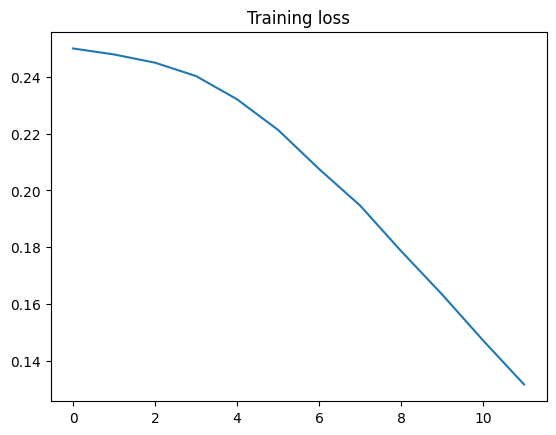

In [ ]:
plt.plot(loss_history)
plt.title('Training loss')
plt.show()

In [ ]:
# Showing some example prediction
model(test_examples[0].reference).cats

{'POSITIVE': 0.7853404879570007, 'NEGATIVE': 0.21465948224067688}

In [ ]:
# Testing the model
def evaluate_model(examples, y_test):
    """
    Function to evaluate the model, given the test examples and the true labels
    """
    correct = 0
    total = 0
    results = []
    for example, y in zip(examples, y_test):
        doc = example.reference
        prediction = model(doc)
        if prediction.cats['POSITIVE'] > prediction.cats['NEGATIVE']:
            prediction = 1
        else:
            prediction = 0
        if prediction == y:
            correct += 1
        total += 1
        results.append(prediction)
    return correct / total, results

accuracy, results = evaluate_model(test_examples, y_test)

In [ ]:
print("Accuracy: ", accuracy)
print(classification_report(y_test, results))

Accuracy:  0.778
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       464
           1       0.77      0.83      0.80       536

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.78      1000
weighted avg       0.78      0.78      0.78      1000



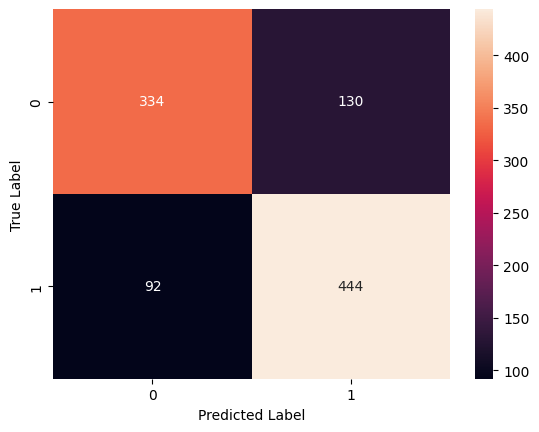

In [ ]:
conf_matrix = confusion_matrix(y_test,
                               results)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Trying different sentences

In [ ]:
# Testing the model with some new examples
reviews = [
    "The film's restoration impressively rejuvenates its visuals, making it a remarkable experience that beautifully preserves the essence of a bygone era.",
    "John Wayne's performance is a revelation, as his youthful vigor and raw talent effortlessly steal the spotlight from his more seasoned co-stars, marking the beginning of his legendary career.",
    "Engrossing from the very first scene to the last, the movie's expertly woven narrative keeps viewers thoroughly engaged, demonstrating the art of storytelling at its finest.",
    "Unearthing this cinematic treasure offers a unique glimpse into John Wayne's burgeoning talent, showcasing his early promise in a way that's both enlightening and inspiring for cinephiles.",
    "Wow, the restoration on this old gem is top-notch! It’s like stepping back in time but with crystal clear vision. John Wayne really knocked it out of the park, even standing next to those old-timers.",
]

negative_reviews = [
    "Tried to get into the whole vintage vibe, but man, was it a snooze fest. Felt like I was watching paint dry, with a plot that just couldn’t decide where it was going.",
    "John Wayne tried, bless his heart, but even he couldn’t save this ship from sinking. The whole thing was just a big yawn with a script that seemed like it was thrown together last minute.",
    "The story was all over the place, like they just tossed a bunch of ideas in a blender and hoped for the best. Couldn’t connect with it at all, and by the end, I was just glad it was over.",
    "The dialogue was so dated, it was almost laughable. And the morals? Don’t even get me started. Felt like a step back in time, and not in a good way. Just couldn’t relate to any of it.",
    "What a missed chance to show off what John Wayne could do. Instead, we got a dull, forgettable movie that’s more a lesson in how not to make a film. Total disappointment."
]

X = reviews + negative_reviews
Y = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
# Create the examples for each review
new_examples = create_examples(X, Y)
accuracy, results = evaluate_model(new_examples, Y)
accuracy

0.9

In [ ]:
# Out of distribution examples
bad_sentences = [
    "Really didn't enjoy this, it wasn't to my taste at all.",
    "Not a fan, sadly. It just didn't do it for me.",
    "Quite disappointing.",
    "Unfortunately, this one wasn't for me. Just couldn't get into it."
]

good_examples = [
    "Very good, it was great.",
    "Absolutely loved it, it was everything I hoped for.",
    "It was amazing, definitely lived up to the hype.",
    "Really enjoyed it, it was a great experience."
]

X = good_examples + bad_sentences
Y = [1, 1, 1, 1, 0, 0, 0, 0]
new_examples = create_examples(X, Y)
accuracy, results = evaluate_model(new_examples, Y)
accuracy

1.0

## Classifier using LSTM

In [15]:
# Creating the vocabulary, word2idx and idx2word
# We do not take out stop words, as they are important for the sentiment analysis
vocabulary = ['<PAD>'] + sorted(list({word for sentence in X for word in sentence.split()}))
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocabsize = len(vocabulary)

In [16]:
# Define the loader
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):

        return self.X[index], self.y[index]

def collate(batch):
    x, y = map(list, zip(*batch))
    x = [torch.tensor(seq) for seq in x]
    y = torch.tensor(y)
    padded_batch = pad_sequence(x, batch_first=True, padding_value=0)
    return padded_batch, y

X_train_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_train]
X_test_idx = [[word2idx[word] for word in sentence.split()] for sentence in X_test]

train_dataset = SentimentDataset(X_train_idx, y_train)
test_dataset = SentimentDataset(X_test_idx, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate)


In [17]:
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, size_embedding, hidden_dim, output_dim, bidirectional, num_layers=1):
        super(SentimentClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, size_embedding)
        self.rnn = nn.LSTM(size_embedding, hidden_dim, batch_first = True, bidirectional = bidirectional, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(int(hidden_dim/2), output_dim)
        )
        self.dropout = nn.Dropout(0.3)
        self.bidirectional = bidirectional
        if self.bidirectional:
            self.fc_bi = nn.Linear(hidden_dim*2, hidden_dim)
        self.num_layers = num_layers
        self.numb_parameters = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print("Model initialized")
        print("Number of parameters: ", self.numb_parameters)

    def forward(self, batch_sentences):
        embeddings = self.word_embeddings(batch_sentences)
        output, (hidden, cell) = self.rnn(embeddings)
        if self.bidirectional:
          hidden = hidden.view(self.num_layers, 2, batch_sentences.size(0), -1)
          hidden = hidden[-1, :, : , :]
          hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
          hidden = self.fc_bi(hidden)
          out = self.fc(self.dropout(hidden))
        else:
          out = self.fc(self.dropout(hidden.squeeze(0)))
        return out

# Define the model

model = SentimentClassifier(vocabsize,
                            size_embedding = 100,
                            hidden_dim = 256,
                            output_dim = 2,
                            bidirectional = True,
                            num_layers=2)

model.to('cuda' if torch.cuda.is_available() else 'cpu')

Model initialized
Number of parameters:  6013698


SentimentClassifier(
  (word_embeddings): Embedding(36704, 100)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_bi): Linear(in_features=512, out_features=256, bias=True)
)

In [18]:
def compute_macro_f1(model, dataloader, criterion):
    """"
    Function to compute the macro F1 score given a model, a dataloader and a criterion
    """
    model.eval()
    # Test set in order to use classification_report
    y_test = []
    results = []
    loss_epoch = 0
    for batch, sentiment in dataloader:
        batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(batch)
        loss = criterion(output, sentiment.to('cuda' if torch.cuda.is_available() else 'cpu'))
        loss_epoch += loss.item()

        # Get the max prediction
        _, prediction = torch.max(output, 1)
        results.append(prediction.detach().cpu())
        y_test.append(sentiment.detach().cpu())

    results = torch.cat(results)
    y_test = torch.cat(y_test)
    return f1_score(y_test, results, average='macro'), loss_epoch/len(dataloader)

def test(model, test_loader):
    """
    A function to generate the predictions given a model and a dataloader
    """
    model.eval()
    y_test = []
    results = []
    for batch, sentiment in test_loader:
        batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
        output = model(batch)
        # Get the max prediction
        _, prediction = torch.max(output, 1)
        results.append(prediction.detach().cpu())
        y_test.append(sentiment)


    results = torch.cat(results)
    y_test = torch.cat(y_test)
    return results, y_test


def train(model, train_loader, criterion, optimizer, n_epochs, test_dataloader):
    squeduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)
    train_hist = {"loss":[], "f1":[]}
    val_hist = {"loss":[], "f1":[]}
    for epoch in range(n_epochs):
        model.train()
        results = []
        gt = []
        loss_epoch = 0
        for batch, y_train in train_loader:
            batch = batch.to('cuda' if torch.cuda.is_available() else 'cpu')
            y_train = y_train.to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, y_train)
            loss.backward()
            loss_epoch += loss.item()
            optimizer.step()
            _, prediction = torch.max(output, 1)
            results.append(prediction.detach().cpu())
            gt.append(y_train.detach().cpu())
        # Store the metrics for each epoch
        squeduler.step()
        train_hist["loss"].append(loss_epoch/len(train_loader))
        train_hist["f1"].append(f1_score(torch.cat(gt), torch.cat(results), average='macro'))
        f1_val, loss_val = compute_macro_f1(model, test_dataloader, criterion)
        val_hist["loss"].append(loss_val)
        val_hist["f1"].append(f1_val)
        print(f"Epoch {epoch + 1} / {n_epochs}, Loss: {loss_epoch/len(train_loader)}, Val macro F1: {f1_val}")

    return model, train_hist, val_hist

In [19]:
# Setting adam optimizer and cross entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
# Training the model
model, train_hist, val_hist = train(model, train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      n_epochs=10,
      test_dataloader=test_loader)

Epoch 1 / 10, Loss: 0.6708299574397859, Val macro F1: 0.5903067673674425
Epoch 2 / 10, Loss: 0.5849187326809716, Val macro F1: 0.6640748034529411
Epoch 3 / 10, Loss: 0.487117719555658, Val macro F1: 0.7159090909090908
Epoch 4 / 10, Loss: 0.37313961959074415, Val macro F1: 0.756111326109391
Epoch 5 / 10, Loss: 0.2350321766876039, Val macro F1: 0.7546995068959477
Epoch 6 / 10, Loss: 0.12746888307470178, Val macro F1: 0.7685720897940291
Epoch 7 / 10, Loss: 0.0901748775430615, Val macro F1: 0.7784681019126924
Epoch 8 / 10, Loss: 0.06547395500635343, Val macro F1: 0.7755250109231132
Epoch 9 / 10, Loss: 0.04429889531687848, Val macro F1: 0.7699963199411191
Epoch 10 / 10, Loss: 0.03353628163255515, Val macro F1: 0.7834586466165414


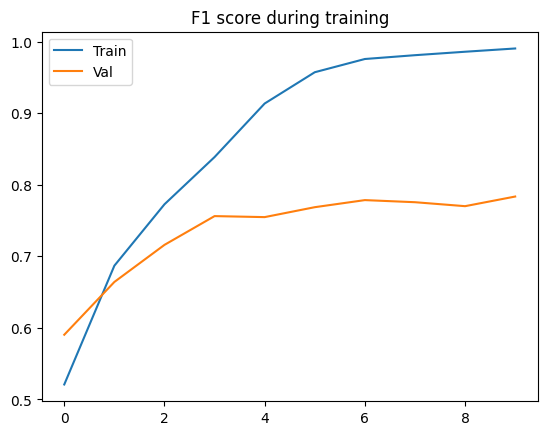

In [20]:
plt.plot(train_hist["f1"], label="Train")
plt.plot(val_hist["f1"], label="Val")
plt.legend()
plt.title("F1 score during training")
plt.show()

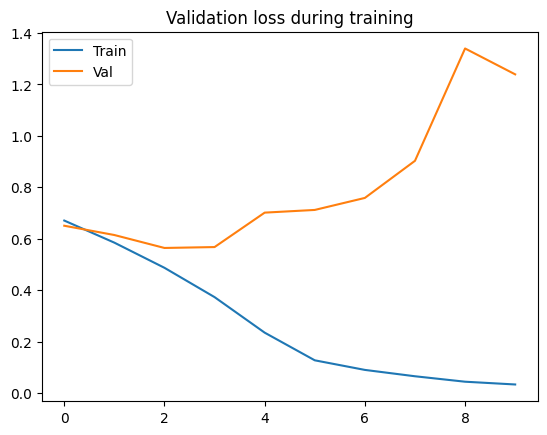

In [21]:
plt.plot(train_hist["loss"], label="Train")
plt.plot(val_hist["loss"], label="Val")
plt.legend()
plt.title("Validation loss during training")
plt.show()

In [22]:
results, y_test = test(model, test_loader)
print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       486
           1       0.78      0.81      0.79       514

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



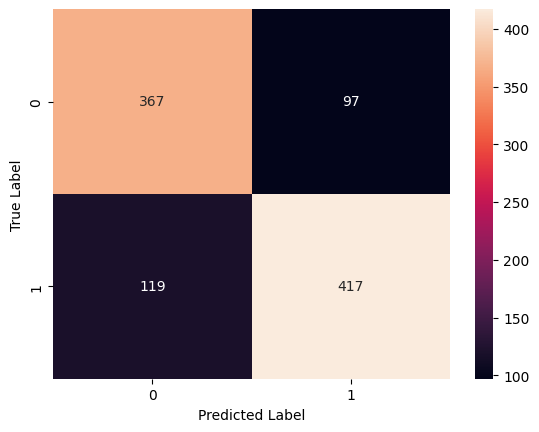

In [23]:
conf_matrix = confusion_matrix(y_test.cpu().numpy(),
                               results.cpu().numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Trying different sentences

In [32]:
# Make it a list of the previous reviews
reviews = [
    "The film's restoration impressively rejuvenates its visuals, making it a remarkable experience that beautifully preserves the essence of a bygone era.",
    "John Wayne's performance is a revelation, as his youthful vigor and raw talent effortlessly steal the spotlight from his more seasoned co-stars, marking the beginning of his legendary career.",
    "Engrossing from the very first scene to the last, the movie's expertly woven narrative keeps viewers thoroughly engaged, demonstrating the art of storytelling at its finest.",
    "Unearthing this cinematic treasure offers a unique glimpse into John Wayne's burgeoning talent, showcasing his early promise in a way that's both enlightening and inspiring for cinephiles.",
    "Wow, the restoration on this old gem is top-notch! It’s like stepping back in time but with crystal clear vision. John Wayne really knocked it out of the park, even standing next to those old-timers.",
]

negative_reviews = [
    "Tried to get into the whole vintage vibe, but man, was it a snooze fest. Felt like I was watching paint dry, with a plot that just couldn’t decide where it was going.",
    "John Wayne tried, bless his heart, but even he couldn’t save this ship from sinking. The whole thing was just a big yawn with a script that seemed like it was thrown together last minute.",
    "The story was all over the place, like they just tossed a bunch of ideas in a blender and hoped for the best. Couldn’t connect with it at all, and by the end, I was just glad it was over.",
    "The dialogue was so dated, it was almost laughable. And the morals? Don’t even get me started. Felt like a step back in time, and not in a good way. Just couldn’t relate to any of it.",
    "What a missed chance to show off what John Wayne could do. Instead, we got a dull, forgettable movie that’s more a lesson in how not to make a film. Total disappointment."
]
# Genreate some examples

X = reviews + negative_reviews
Y = [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]

X_idx = [[word2idx[word] for word in sentence.split() if word in word2idx.keys()] for sentence in X]

new_dataset = SentimentDataset(X_idx, Y)

loader = DataLoader(new_dataset, batch_size=10, shuffle=True, collate_fn=collate)

results, y = test(model, loader)
classification_report(results, y, output_dict=True)["accuracy"]


0.7

In [33]:
# Out of distribution examples
bad_sentences = [
    "Really didn't enjoy this, it wasn't to my taste at all.",
    "Not a fan, sadly. It just didn't do it for me.",
    "Quite disappointing.",
    "Unfortunately, this one wasn't for me. Just couldn't get into it."
]

good_examples = [
    "Very good, it was great.",
    "Absolutely loved it, it was everything I hoped for.",
    "It was amazing, definitely lived up to the hype.",
    "Really enjoyed it, it was a great experience."
]

X = good_examples + bad_sentences
Y = [1, 1, 1, 1, 0, 0, 0, 0]

X_idx = [[word2idx[word] for word in sentence.split() if word in word2idx.keys()] for sentence in X]

new_dataset = SentimentDataset(X_idx, Y)

loader = DataLoader(new_dataset, batch_size=10, shuffle=True, collate_fn=collate)

results, y = test(model, loader)
classification_report(results, y, output_dict=True)["accuracy"]

0.5

In [54]:
# Looking at the probabilities of some specific sentences
softmax = nn.Softmax(dim=1)

probs = softmax(model(torch.tensor(new_dataset[0][0]).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu'))).detach().cpu().numpy()[0]
print("Sentence:", X[0])
print(f"Probability negative review: {probs[0]:.2f}, Probability positive review {probs[1]:.2f}")

Sentence: Very good, it was great.
Probability negative review: 0.35, Probability positive review 0.65


In [60]:
probs = softmax(model(torch.tensor(new_dataset[6][0]).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu'))).detach().cpu().numpy()[0]
print("Sentence:", X[6])
print(f"Probability negative review: {probs[0]:.2f}, Probability positive review {probs[1]:.2f}")

Sentence: Quite disappointing.
Probability negative review: 0.81, Probability positive review 0.19
